# **Lecture 3: Mean-Variance Portfolios and ESG Investing**


## **Part II: ESG Efficient Frontier**

**Objective**: Explore the impact of ESG constraints on portfolio optimization by constructing <br>
efficient frontiers and comparing them with and without ESG score limits.


### **1. Import and clean the return data**
Read the monthly return data, ensure returns are numeric, and remove invalid entries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("sample_esg_monthly_returns.csv", parse_dates=["date"])
df["return"] = pd.to_numeric(df["RET"], errors="coerce")
df = df[["date", "TICKER", "return"]].copy()
df = df.dropna(subset=["return"])

display(df)

/var/folders/bs/5f0ys9r13_l1yqx_3qv0ncg80000gn/T/ipykernel_87040/630388294.py:5: DtypeWarning: Columns (9,24,49,58) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("sample_esg_monthly_returns.csv", parse_dates=["date"])


,date,TICKER,return
0,2004-01-30,ORCL,0.047619
1,2004-02-27,ORCL,-0.071429
2,2004-03-31,ORCL,-0.067599
3,2004-04-30,ORCL,-0.062500
4,2004-05-28,ORCL,0.013333
...,...,...,...
112079,2024-08-30,TSLA,-0.077390
112080,2024-09-30,TSLA,0.221942
112081,2024-10-31,TSLA,-0.045025
112082,2024-11-29,TSLA,0.381469


### **2. Compute the return matrix**

Transform the data so each column represents a ticker and each row a monthly return. <br>
Ensure there are no duplicate dates and keep only assets with long enough histories

In [39]:
series_by_ticker = {}
for t, g in df.groupby("TICKER", sort=True):
    s = g.set_index("date")["return"].sort_index()
    # make sure there are no duplicate dates left
    if not s.index.is_unique:
        s = s.groupby(level=0).last()  # aggregate any residual duplicates
    series_by_ticker[t] = s

rets = pd.concat(series_by_ticker, axis=1)
rets.columns.name = None
rets.index.name = "date"

In [40]:
rets = rets.replace([np.inf, -np.inf], np.nan)

# require >= 250 months per ticker
rets = rets.loc[:, rets.count() >= 250]

rets = rets.dropna(how="any")

### **3. Compute expected returns and covariance matrix**

In [41]:
# ---------- Define mu and S
mu = rets.mean() * 12    # expected annual return (Series)
S  = rets.cov()  * 12    # annual covariance (DataFrame)

### **4. Find the Maximum Sharpe Ratio portfolio**

Use the EfficientFrontier class to maximize the Sharpe ratio and report weights and performance metrics.

In [42]:
from pypfopt import EfficientFrontier

ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
ef.max_sharpe()
w_base = ef.clean_weights()
Rb, Vb, Sb = ef.portfolio_performance()

# Top 10 by weight
top10 = (pd.Series(w_base)
         .sort_values(ascending=False)
         .head(10)
         .rename_axis("Ticker")
         .reset_index(name="Weight (%)"))

top10["Weight (%)"] = (top10["Weight (%)"] * 100).round(2)
display(top10.set_index("Ticker",drop=True))

print(f"Return: {Rb:.2%}  Vol: {Vb:.2%}  Sharpe: {Sb:.2f}")

,Weight (%)
Ticker,
CHD,14.10
TYL,11.25
AAPL,10.59
LLY,7.86
MCD,7.63
ODFL,6.00
GILD,4.63
AZO,4.37
WEC,4.20


Return: 21.33%  Vol: 11.78%  Sharpe: 1.81


### **5. Plot the baseline Efficient Frontier**

In [43]:
# Target Returns
t = np.linspace(float(mu.min()), float(mu.max()), 60)

# Build frontier
xb, yb = [], []
for r in t:
    ef_b = EfficientFrontier(mu, S, weight_bounds=(0, 1))
    try:
        ef_b.efficient_return(r) 
        R, V, _ = ef_b.portfolio_performance()
        yb.append(R); xb.append(V)
    except Exception:
        pass  # skip infeasible targets

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


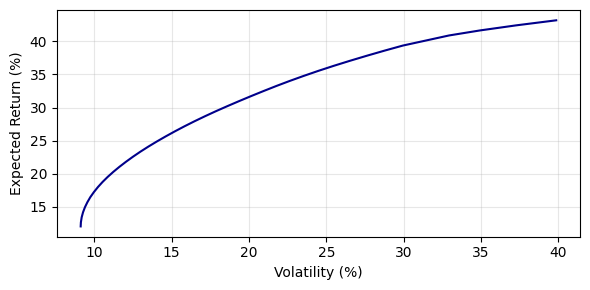

In [44]:
# Plot
plt.figure(figsize=(6, 3))
plt.plot(np.dot(xb, 100), np.dot(yb, 100), linewidth=1.5, color="darkblue")
plt.xlabel("Volatility (%)")
plt.ylabel("Expected Return (%)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### **6. Import ESG data**
 Keep only the most recent ESG score for each ticker and align it with the return data.


In [45]:
esg = pd.read_csv("sample_esg.csv", usecols=["Ticker", "Year", "ESG Score"])
esg = esg.sort_values(["Ticker", "Year"]).drop_duplicates("Ticker", keep="last")
esg = esg.set_index("Ticker")["ESG Score"].reindex(mu.index)
display(esg)

A       88.809693
AAP     66.167809
AAPL    80.381927
ABT     82.552676
ACGL    24.540943
          ...    
XOM     68.659041
XRAY    71.598097
YUM     78.060454
ZBRA    48.676768
ZION    52.072684
Name: ESG Score, Length: 310, dtype: float64

### **7. Add ESG as a constraint (ESG ≥ 79)**

Restrict the optimization to portfolios whose weighted-average ESG score is at least 79. <br>
Remove any assets with missing ESG scores.

In [46]:
# drop missing ESG tickers
if esg.isna().any():
    keep = esg.dropna().index
    mu  = mu.loc[keep]
    cov = S.loc[keep, keep]
    esg = esg.loc[keep]

ESG_THRESHOLD = 79

ef_esg = EfficientFrontier(mu, cov, weight_bounds=(0, 1))
ef_esg.add_constraint(lambda w: w @ esg.values >= ESG_THRESHOLD)
ef_esg.max_sharpe()

OrderedDict([('A', 0.0),
             ('AAP', 0.0),
             ('AAPL', 0.111175025875098),
             ('ABT', 0.0),
             ('ACGL', 0.0),
             ('ADBE', 0.0),
             ('ADI', 0.0),
             ('ADM', 0.0068397728836108),
             ('ADP', 0.0),
             ('ADSK', 0.0),
             ('AEE', 0.0),
             ('AEP', 0.0),
             ('AES', 0.0),
             ('AFL', 0.0),
             ('AIG', 0.0),
             ('AIZ', 0.0),
             ('AKAM', 0.0),
             ('ALB', 0.0),
             ('ALGN', 0.0),
             ('ALK', 0.0),
             ('ALL', 0.0),
             ('AMAT', 0.0),
             ('AMD', 0.0),
             ('AME', 0.0),
             ('AMGN', 0.0),
             ('AMT', 0.0),
             ('ANSS', 0.0),
             ('APA', 0.0),
             ('APD', 0.0),
             ('APH', 0.0),
             ('ARE', 0.0),
             ('AVB', 0.0),
             ('AVY', 0.0),
             ('AXP', 0.0),
             ('AZO', 0.0249367682390373),
    

### **8. Report ESG-constrained portfolio performance**

Display the portfolio composition and performance metrics under the ESG constraint

In [47]:
w_esg = ef_esg.clean_weights()
Re, Ve, Se = ef_esg.portfolio_performance()

top10_esg = (
    pd.Series(w_esg, name="Weight")
      .sort_values(ascending=False)
      .head(10)
      .rename_axis("Ticker")
      .reset_index()
)
top10_esg["Weight (%)"] = (top10_esg["Weight"] * 100).round(2)

# minimal column order
cols = ["Ticker", "Weight (%)"] if "Name" not in top10_esg.columns else ["Ticker", "Name", "Weight (%)"]
top10_esg = top10_esg[cols].set_index("Ticker",drop=True)

display(top10_esg)

print(f"\nReturn: {Re:.2%}  Volatility: {Ve:.2%}  Sharpe: {Se:.2f}")

,Weight (%)
Ticker,
HSY,16.19
AAPL,11.12
MCD,10.77
WMT,9.19
TYL,7.27
MO,5.96
CHD,5.34
GILD,4.76
NVDA,4.75



Return: 19.77%  Volatility: 11.67%  Sharpe: 1.69


### **9. Plot the relationship between ESG threshold and Max Sharpe Ratio**

Observe how portfolio efficiency changes as the minimum ESG threshold increases.

In [48]:
# Choose the ESG score cutoffs you want to test
thresholds = np.linspace(60,100, 30)
tested_thr, sharpes, vols, rets = [], [], [], []

# Only use assets that have ESG scores
idx = esg.dropna().index
mu_t  = mu.loc[idx]
cov_t = cov.loc[idx, idx]
esg_t = esg.loc[idx].values  # vector aligned to mu_t/cov_t

for thr in thresholds:
    ef = EfficientFrontier(mu_t, cov_t, weight_bounds=(0, 1))
    # bind current values into the lambda to avoid late-binding issues
    ef.add_constraint(lambda w, e=esg_t, T=thr: w @ e >= T)
    try:
        ef.max_sharpe()
        R, V, S_ = ef.portfolio_performance()
        tested_thr.append(thr)
        sharpes.append(S_)
        vols.append(V)
        rets.append(R)
    except Exception:
        # infeasible threshold –> skip
        continue

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


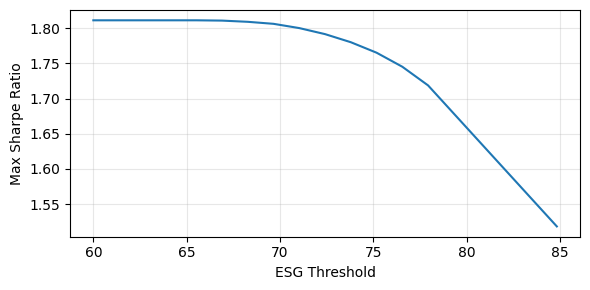

In [49]:
plt.figure(figsize=(6, 3))
plt.plot(tested_thr, sharpes)
plt.xlabel("ESG Threshold")
plt.ylabel("Max Sharpe Ratio")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### **10. Plot both Efficient Frontiers (baseline vs ESG ≥ 79)**

Display both frontiers on the same plot to visualize the impact of ESG constraints on the risk–return trade-off.

In [50]:
mu_base = mu.copy()
S_base  = S.loc[mu.index, mu.index].copy()

# --- Build ESG-aligned stats (tickers with ESG only) ---
idx_esg = esg.dropna().index
mu_esg  = mu.loc[idx_esg]
cov_esg = S.loc[idx_esg, idx_esg]
esg_vec = esg.loc[idx_esg].values

# --- Common target-return grid
low = float(min(mu_base.min(), mu_esg.min())) + 1e-6
high = float(max(mu_base.max(), mu_esg.max())) - 1e-6
t  = np.linspace(low, high, 40)

# ----- Baseline frontier
xb, yb = [], []
for r in t:
    ef_b = EfficientFrontier(mu_base, S_base, weight_bounds=(0, 1))
    try:
        ef_b.efficient_return(r)
        R, V, _ = ef_b.portfolio_performance()
        yb.append(R); xb.append(V)
    except Exception:
        pass  # infeasible target -> skip

# ----- ESG-constrained frontier
xe, ye = [], []
for r in t:
    ef_e = EfficientFrontier(mu_esg, cov_esg, weight_bounds=(0, 1))
    ef_e.add_constraint(lambda w: w @ esg_vec >= ESG_THRESHOLD)
    try:
        ef_e.efficient_return(r)
        R, V, _ = ef_e.portfolio_performance()
        ye.append(R); xe.append(V)
    except Exception:
        pass  # infeasible target -> skip


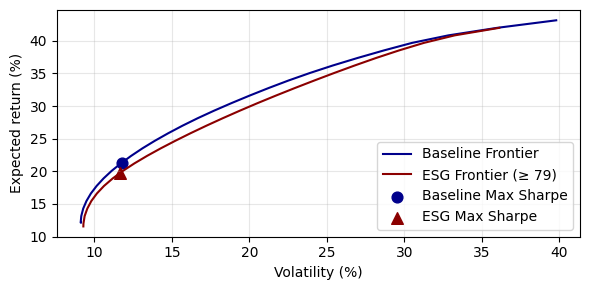

In [51]:
# Plot both curves and max-Sharpe 
plt.figure(figsize=(6, 3))
plt.plot(np.dot(100, xb), np.dot(100, yb), label="Baseline Frontier", color="darkblue")
plt.plot(np.dot(100, xe), np.dot(100, ye), label=f"ESG Frontier (≥ {ESG_THRESHOLD:g})", color="darkred")
plt.scatter([Vb*100], [Rb*100], s=60, label="Baseline Max Sharpe", color="darkblue")
plt.scatter([Ve*100], [Re*100], s=70, marker="^", label="ESG Max Sharpe", color="darkred")    
plt.xlabel("Volatility (%)")
plt.ylabel("Expected return (%)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()